In [ ]:
#sempre lembrar de limpar a pasta tmp ao final do exercício

# import shutil
# shutil.rmtree('/tmp_img')
# shutil.rmtree('/tmp_csv')
# shutil.rmtree('/tmp_img_resized')

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import cv2
import glob
import os
import re
from google.colab import drive
from functools import lru_cache
import requests

In [2]:
RESCALE_RATIO = 35
states = ['AC', 'AL', 'AP', 'AM', 'BA', 'CE', 'ES', 'GO', 'MA', 'MT', 'MS', 'MG', 'PA', 'PB', 'PR', 'PE', 'PI', 'RJ', 'RN', 'RS', 'RO', 'RR', 'SC', 'SP', 'SE', 'TO', 'DF']

In [3]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
def open_image_internet(url):
  return cv2.imdecode(np.asarray(bytearray(requests.get(url).content)), -1)

def open_image_local(path):
  img = cv2.imread(path, cv2.COLOR_BGR2RGB)
  return img

def BGR2RGB(img):
  return img[:,:,::-1]
  
def crop_image(img_orig):
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml')
  gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)
  faces = face_cascade.detectMultiScale(gray, 1.3, 5)
  if len(faces):
    (x,y,w,h) = faces[0]
    img_cropped = img_orig[
        max(0,y-30):
        min(img_orig.shape[0]-1,y+h+30), 
        max(0, x-30):
        min(img_orig.shape[1]-1,x+w+30),
        :]
    return img_cropped
  else:
    square = min(img_orig.shape[0], img_orig.shape[1])//2
    mid_height = img_orig.shape[0]//2
    mid_width = img_orig.shape[1]//2
    return img_orig[mid_height-square:mid_height+square,mid_width-square:mid_width+square]

def unzip_files(input_folder, file, output_folder):
  from_path = f'{input_folder}/{file}'
  zip_ref = zipfile.ZipFile(from_path, 'r')
  zip_ref.extractall(output_folder)
  zip_ref.close()

@lru_cache(maxsize=None)
def get_img_filenames(state):
  os.chdir('/tmp_img')
  img_lists = [glob.glob(e) for e in ('*'+state+'*.jpg', '*'+state+'*.png', '*'+state+'*.jpeg')]
  img_list = [item for sublist in img_lists for item in sublist]
  return set(img_list)

def get_img_filename_from_sq_candidato(state, sq_candidato):
  filenames = get_img_filenames(state)
  option1, option2 = 'F'+state+str(sq_candidato)+'_div.jpg', 'F'+state+str(sq_candidato)+'_div.jpeg'
  if option1 in filenames:
    return option1
  elif option2 in filenames:
    return option2
  else:
    return ''

def get_candidates_from_state(state):
  os.chdir('/tmp_csv')
  data_filename = glob.glob('*'+state+'.csv')
  data_df = pd.read_csv(r'/tmp_csv/'+data_filename[0], encoding='iso-8859-1', on_bad_lines='warn', sep=';')
  data_df['filename'] = data_df['SQ_CANDIDATO'].map(lambda sq_candidato: get_img_filename_from_sq_candidato(state, sq_candidato))
  return data_df[['NM_CANDIDATO', 'DS_CARGO', 'SQ_CANDIDATO', 'DS_SIT_TOT_TURNO', 'CD_SIT_TOT_TURNO', 'filename']].query('filename != ""') 

def get_candidates():
  return pd.concat([get_candidates_from_state(state) for state in states])

def get_elected(candidate_df):
  return candidate_df.query('DS_SIT_TOT_TURNO == "ELEITO" or DS_SIT_TOT_TURNO == "ELEITO POR MÉDIA"') 

def get_not_elected(candidate_df):
  return candidate_df.query('DS_SIT_TOT_TURNO == "NÃO ELEITO"')

def get_faces(elected_df):
  return np.array([open_image_local('/tmp_img/'+filename) for filename in elected_df['filename'].values])

def get_cropped_faces(faces):
  return np.array([crop_image(face) for face in faces])

def get_resized_faces_aux(cropped_faces, x_max, y_max):
  return np.array([cv2.resize(cropped_face, (x_max, y_max), interpolation = cv2.INTER_AREA) for cropped_face in cropped_faces])

def get_resized_faces(cropped_faces):
  y_max = np.max([cropped_face.shape[0] for cropped_face in cropped_faces])
  x_max = np.max([cropped_face.shape[1] for cropped_face in cropped_faces])
  return get_resized_faces_aux(cropped_faces, x_max, y_max)
  
def get_flatten_faces(faces):
  return faces.reshape((faces.shape[0], np.prod(faces.shape[1:])))

def output_imgs(folder, candidates_df, resized_imgs):
  if not os.path.exists(folder):
    os.makedirs(folder)
  os.chdir(folder)

  for idx_row in range(candidates_df.shape[0]):
    filename = candidates_df.iloc[idx_row]['filename']
    if filename != '':
      cv2.imwrite(filename, resized_imgs[idx_row])
    else:
      continue

Unzip Files

In [5]:
unzip_files('/content/gdrive/MyDrive/Bootcamp_ENAP_2022/2022', 'consulta_cand_2022.zip', '/tmp_csv')
for state in states:
  unzip_files('/content/gdrive/MyDrive/Bootcamp_ENAP_2022/2022', 'foto_cand2022_'+state+'_div.zip', '/tmp_img')

Save Resized Images (Only Play Me Once)

In [ ]:
candidates_df = get_candidates()
candidates_faces = get_faces(candidates_df)
candidates_faces = get_cropped_faces(candidates_faces)
candidates_faces = get_resized_faces(candidates_faces)
output_imgs('/tmp_img_resized',  candidates_df, candidates_faces)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
from google.colab import files
!zip -r /content/img_resized.zip /tmp_img_resized
files.download("/content/img_resized.zip")

Play for Real

In [6]:
elected_df = get_elected(get_candidates())
elected_faces = get_faces(elected_df)
cropped_elected_faces = get_cropped_faces(elected_faces)
resized_cropped_ellected_faces = get_resized_faces(cropped_elected_faces)
elected_flattened_faces = get_flatten_faces(resized_cropped_ellected_faces)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Faces: variável com os rostos dos candidatos eleitos

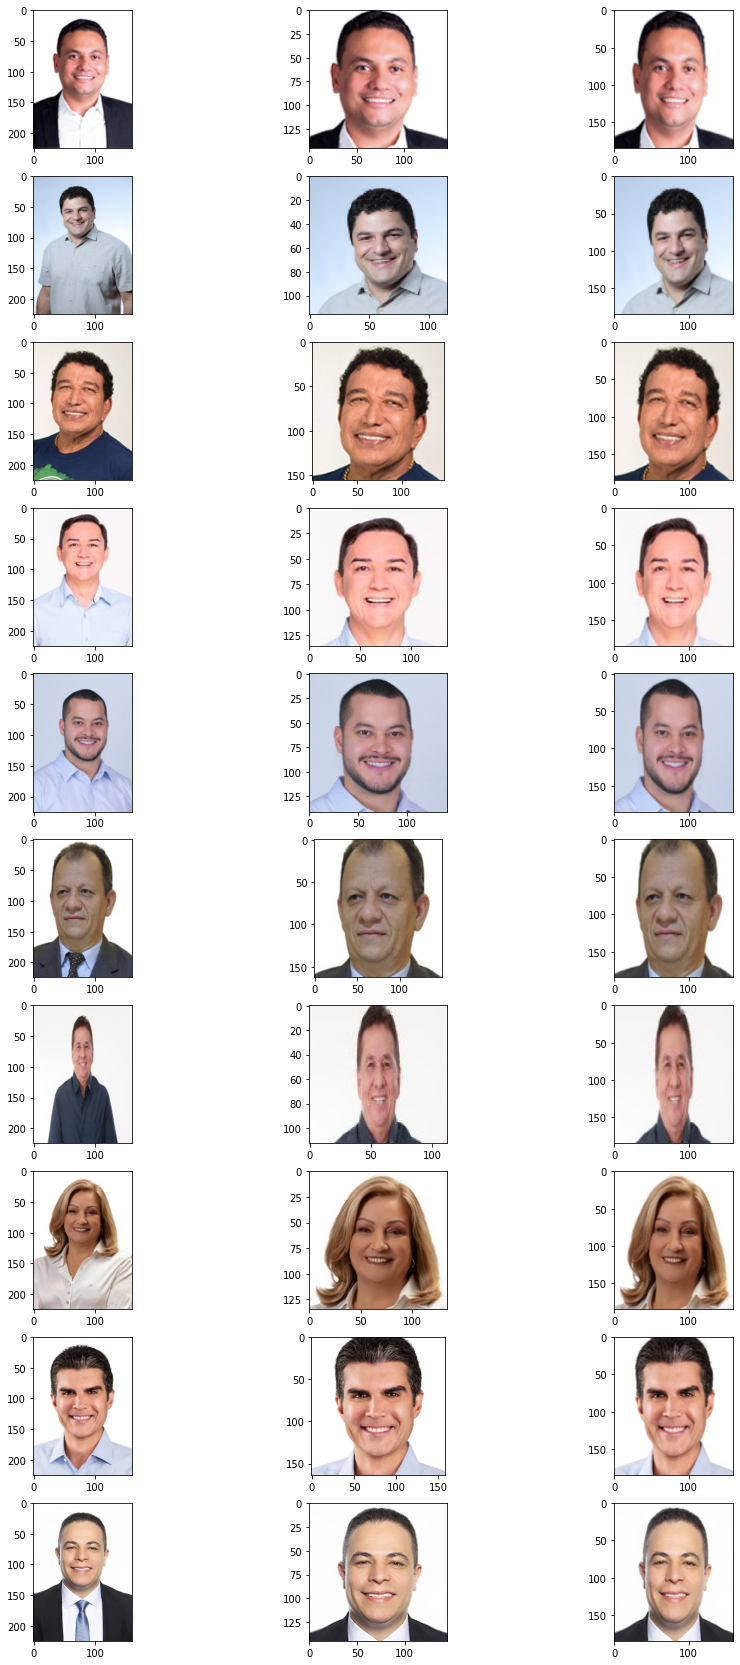

In [7]:
n_rows = 10
n_cols = 3

lines = np.random.choice(elected_faces.shape[0], n_rows, replace=False)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15,30))
for idx, (img_orig, img_cropp, img_resized) in enumerate(zip(elected_faces[lines], cropped_elected_faces[lines], resized_cropped_ellected_faces[lines])):
  axs[idx][0].imshow(BGR2RGB(img_orig));
  axs[idx][1].imshow(BGR2RGB(img_cropp));
  axs[idx][2].imshow(BGR2RGB(img_resized));

PCA

Fonte: https://github.com/lewagon/data-challenges/blob/master/05-ML/06-Unsupervised-Learning/02-Face-Recognition/face_recognition.ipynb

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

Construir o PCA dos candidatos eleitos com 10 componentes

In [9]:
#verificar se realmente é necessário normalizar
elected_flattened_faces = MinMaxScaler().fit_transform(elected_flattened_faces)
pca = PCA(n_components=50, svd_solver='full').fit(elected_flattened_faces)
data_projected = pca.transform(elected_flattened_faces)

Play

Avaliar os metadados do PCA

In [10]:
pca.components_.shape

(50, 88800)

Reconstrução dos rostos dos candidatos a partir da operação inversa da transformação do PCA

In [11]:
data_reconstructed = pca.inverse_transform(data_projected)

Imagem Original vs. Reconstrução de uma Imagem 

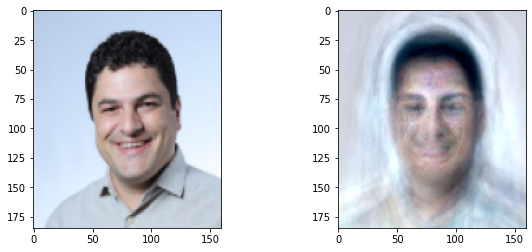

In [12]:
ith = lines[np.random.randint(lines.shape[0])]
elected_person_image = resized_cropped_ellected_faces[ith]
elected_person_reconstructed_image = data_reconstructed[ith].reshape(resized_cropped_ellected_faces[ith].shape)
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].imshow(BGR2RGB(elected_person_image));
axs[1].imshow(BGR2RGB(elected_person_reconstructed_image));

Imagens Reconstruídas

Reconstrução da imagem padrão de candidatos eleitos a partir do componente principal

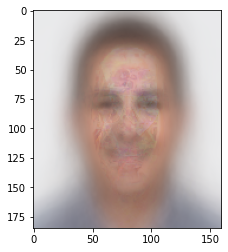

In [13]:
plt.imshow(BGR2RGB(pca.mean_.reshape(elected_person_reconstructed_image.shape)));

Busca pelo número ideal de componentes principais

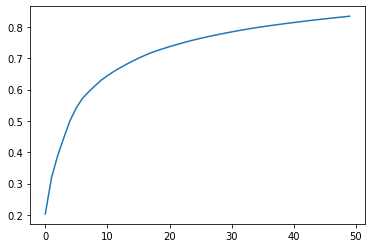

In [14]:
import seaborn as sns
sns.lineplot(x=np.arange(pca.explained_variance_ratio_.shape[0]), y=pca.explained_variance_ratio_.cumsum())

Reconstrução da imagem padrão de candidatos eleitos a partir das componentes principais

In [17]:
def plot_main_components(pca, n_components=1):
  sc = MinMaxScaler()
  sc = sc.fit(pca.components_)
  input_transformado = sc.transform(pca.components_[0:n_components])
  input_transformado = np.expand_dims(input_transformado.mean(axis=0), axis=1)
  input_transformado = input_transformado.reshape(elected_person_reconstructed_image.shape)
  plt.imshow(BGR2RGB(input_transformado));

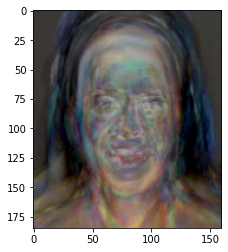

In [18]:
n_components = 1
plot_main_components(pca, n_components)

Autoencoder

Fonte: https://github.com/heliomacedofilho/data-challenges/blob/master/06-Deep-Learning/03-Convolutional-Neural-Networks/05-Autoencoder/autoencoders.ipynb

In [51]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape, Conv2DTranspose, Input, BatchNormalization, Dropout, Lambda, LeakyReLU
from tensorflow.keras import Model, backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import seaborn as sns

In [20]:
latent_dimension = 200

In [21]:
candidates_df = get_candidates()

In [22]:
elected_df = get_elected(candidates_df)[['filename']].copy()
elected_df['y'] = 1

In [23]:
not_elected_df = get_not_elected(candidates_df)[['filename']]
not_elected_indices = np.random.choice(not_elected_df.shape[0], elected_df.shape[0], replace=False)
not_elected_df = not_elected_df.iloc[not_elected_indices].copy()
not_elected_df['y'] = 0

In [24]:
#candidates_df = pd.concat([elected_df, not_elected_df], axis=0).sample(frac=1)

In [25]:
candidates_df = elected_df

In [26]:
X = get_resized_faces(get_cropped_faces(get_faces(candidates_df.drop(columns='y'))))/255
y = candidates_df['y']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


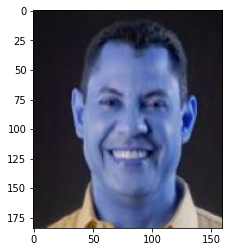

In [56]:
plt.imshow(X[0])

In [57]:
#Gambiarra para o autoencoder funcionar (input e ouput têm que ter as mesmas dimensões. Voltar aqui para consertar.)
X = get_resized_faces_aux(X, 160, 192)

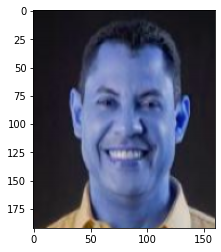

In [58]:
plt.imshow(X[0])

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Encoder

In [60]:
mean_mu = None
log_var = None

In [61]:
def build_prefix_encoder(input_shape, use_batch_norm = False, use_dropout = False):
    # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
    # BatchNormalization and Dropout.
    # Otherwise, the names of above mentioned layers in the model 
    # would be inconsistent
    global K
    K.clear_session()

    '''returns an encoder model, of output_shape equals to latent_dimension'''
    encoder = Sequential()
    
    encoder.add(Conv2D(32, (3,3), (2, 2), padding='same', input_shape=input_shape, activation='LeakyReLU'))
    if use_batch_norm: encoder.add(BatchNormalization())
    if use_dropout: encoder.add(Dropout(0.25))

    encoder.add(Conv2D(64, (3,3), (2, 2), padding='same', activation='LeakyReLU'))
    if use_batch_norm: encoder.add(BatchNormalization())
    if use_dropout: encoder.add(Dropout(0.25))

    encoder.add(Conv2D(64, (3,3), (2, 2), padding='same', activation='LeakyReLU'))
    if use_batch_norm: encoder.add(BatchNormalization())
    if use_dropout: encoder.add(Dropout(0.25))

    encoder.add(Conv2D(64, (3,3), (2, 2), padding='same', activation='LeakyReLU'))
    if use_batch_norm: encoder.add(BatchNormalization())
    if use_dropout: encoder.add(Dropout(0.25))

    shape_before_flattening = K.int_shape(encoder.layers[-1].output)[1:] 

    encoder.add(Flatten())

    return encoder, shape_before_flattening

def build_suffix_encoder(prefix_model, latent_dimension):
  prefix_model_input = prefix_model.layers[0].input
  prefix_model_output = prefix_model.layers[-1].output

  mean_mu = Dense(latent_dimension)(prefix_model_output)
  log_var = Dense(latent_dimension)(prefix_model_output)

  # Defining a function for sampling
  def sampling(args):
    global mean_mu
    global log_var
    mean_mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
    return mean_mu + K.exp(log_var/2)*epsilon

  concatenate = Lambda(sampling)([mean_mu, log_var])
  return Model(prefix_model_input, concatenate)

def build_encoder(input_shape, use_batch_norm = False, use_dropout = False, latent_dimension=200):
  prefix_encoder, shape_before_flattening = build_prefix_encoder(input_shape, use_batch_norm, use_dropout)
  encoder = build_suffix_encoder(prefix_encoder, latent_dimension)
  return encoder, shape_before_flattening

In [62]:
encoder_model, shape_before_flattening = build_encoder(X_train.shape[1:], False, False, latent_dimension)
encoder_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_input (InputLayer)      [(None, 192, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 96, 80, 32)   896         ['conv2d_input[0][0]']           
                                                                                                  
 conv2d_1 (Conv2D)              (None, 48, 40, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 24, 20, 64)   36928       ['conv2d_1[0][0]']           

Decoder

In [63]:
def build_decoder(input_shape, latent_dimension, shape_before_flattening):
    decoder = Sequential()
    decoder.add(Dense(np.prod(shape_before_flattening), input_shape=(latent_dimension, ), activation=None))
    decoder.add(Reshape(shape_before_flattening))
    decoder.add(Conv2DTranspose(64, kernel_size=(3,3), strides=(2,2), padding='same', activation='LeakyReLU'))
    decoder.add(Conv2DTranspose(64, kernel_size=(3,3), strides=(2,2), padding='same', activation='LeakyReLU'))
    decoder.add(Conv2DTranspose(32, kernel_size=(3,3), strides=(2,2), padding='same', activation='LeakyReLU'))
    decoder.add(Conv2DTranspose(3, kernel_size=(3,3), strides=(2,2), padding='same', activation='sigmoid'))
    return decoder

In [78]:
decoder_model = build_decoder(X_train.shape[1:], latent_dimension, shape_before_flattening)
decoder_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 7680)              1543680   
                                                                 
 reshape_1 (Reshape)         (None, 12, 10, 64)        0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 24, 20, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 48, 40, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 96, 80, 32)       18464     
 ranspose)                                                       
                                                      

Autoencoder

In [80]:
def build_autoencoder(input_shape, latent_dimension):
    encoder, shape_before_flattening = build_encoder(input_shape, True, True, latent_dimension)
    decoder = build_decoder(encoder.layers[-1].output, latent_dimension, shape_before_flattening)
    autoencoder = Model(encoder.layers[0].input, decoder(encoder.layers[-1].output))
    return autoencoder

In [81]:
autoencoder = build_autoencoder(X_train.shape[1:], latent_dimension)
autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_input (InputLayer)      [(None, 192, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 96, 80, 32)   896         ['conv2d_input[0][0]']           
                                                                                                  
 batch_normalization (BatchNorm  (None, 96, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [82]:
LEARNING_RATE = 0.0005
N_EPOCHS = 200
LOSS_FACTOR = 10000
BATCH_SIZE = 32

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])
  
def kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = 1)
    return kl_loss

def total_loss(y_true, y_pred):
    return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)
  
adam_optimizer = Adam(lr = LEARNING_RATE)

autoencoder.compile(optimizer=adam_optimizer, loss = total_loss, metrics = [r_loss, kl_loss])

#checkpoint_vae = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'VAE/weights.h5'), save_weights_only = True, verbose=1)
es = EarlyStopping(patience=5, restore_best_weights=True)

autoencoder.fit(X_train, X_train,
                shuffle=True,
                epochs = N_EPOCHS,
                initial_epoch = 0,
                steps_per_epoch=X_train.shape[0] / BATCH_SIZE,
                callbacks=es)
                #callbacks=[checkpoint_vae])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/200
12/11 [===============================] - ETA: 0s - loss: 1564.9900 - r_loss: 0.1135 - kl_loss: 430.3150

11/11 [==============================] - 2s 49ms/step - loss: 1564.9900 - r_loss: 0.1135 - kl_loss: 430.3150
Epoch 2/200
11/11 [===========================>..] - ETA: 0s - loss: 1377.7261 - r_loss: 0.1055 - kl_loss: 322.8656

11/11 [==============================] - 0s 42ms/step - loss: 1373.3125 - r_loss: 0.1052 - kl_loss: 321.7691
Epoch 3/200
11/11 [===========================>..] - ETA: 0s - loss: 1070.3976 - r_loss: 0.0741 - kl_loss: 329.4284

11/11 [==============================] - 0s 42ms/step - loss: 1058.5361 - r_loss: 0.0730 - kl_loss: 328.8855
Epoch 4/200
11/11 [===========================>..] - ETA: 0s - loss: 802.0132 - r_loss: 0.0487 - kl_loss: 314.7133

11/11 [==============================] - 0s 42ms/step - loss: 800.8699 - r_loss: 0.0486 - kl_loss: 314.9566
Epoch 5/200
11/11 [===========================>..] - ETA: 0s - loss: 742.0552 - r_loss: 0.0423 - kl_loss: 319.3040

11/11 [==============================] - 0s 42ms/step - loss: 738.6703 - r_loss: 0.0420 - kl_loss: 318.2640
Epoch 6/200
11/11 [===========================>..] - ETA: 0s - loss: 686.6550 - r_loss: 0.0389 - kl_loss: 297.1898

11/11 [==============================] - 0s 41ms/step - loss: 685.1181 - r_loss: 0.0388 - kl_loss: 297.5832
Epoch 7/200
11/11 [===========================>..] - ETA: 0s - loss: 638.9058 - r_loss: 0.0356 - kl_loss: 283.3217

11/11 [==============================] - 0s 42ms/step - loss: 638.2686 - r_loss: 0.0355 - kl_loss: 283.1971
Epoch 8/200
11/11 [===========================>..] - ETA: 0s - loss: 604.7213 - r_loss: 0.0335 - kl_loss: 269.7846

11/11 [==============================] - 0s 41ms/step - loss: 603.5517 - r_loss: 0.0334 - kl_loss: 269.4525
Epoch 9/200
11/11 [===========================>..] - ETA: 0s - loss: 584.7809 - r_loss: 0.0322 - kl_loss: 263.0195

11/11 [==============================] - 0s 42ms/step - loss: 587.0549 - r_loss: 0.0324 - kl_loss: 263.0435
Epoch 10/200
11/11 [===========================>..] - ETA: 0s - loss: 585.5500 - r_loss: 0.0321 - kl_loss: 264.3472

11/11 [==============================] - 0s 41ms/step - loss: 587.3232 - r_loss: 0.0321 - kl_loss: 266.0665
Epoch 11/200
11/11 [===========================>..] - ETA: 0s - loss: 558.8425 - r_loss: 0.0298 - kl_loss: 261.0726

11/11 [==============================] - 0s 42ms/step - loss: 558.4217 - r_loss: 0.0298 - kl_loss: 260.6612
Epoch 12/200
11/11 [===========================>..] - ETA: 0s - loss: 545.0507 - r_loss: 0.0301 - kl_loss: 243.7599

11/11 [==============================] - 0s 41ms/step - loss: 545.6826 - r_loss: 0.0303 - kl_loss: 242.6351
Epoch 13/200
11/11 [===========================>..] - ETA: 0s - loss: 521.3585 - r_loss: 0.0284 - kl_loss: 237.4567

11/11 [==============================] - 0s 42ms/step - loss: 519.6754 - r_loss: 0.0283 - kl_loss: 236.8358
Epoch 14/200
11/11 [===========================>..] - ETA: 0s - loss: 514.1492 - r_loss: 0.0283 - kl_loss: 231.1526

11/11 [==============================] - 0s 42ms/step - loss: 512.6545 - r_loss: 0.0281 - kl_loss: 231.1675
Epoch 15/200
11/11 [===========================>..] - ETA: 0s - loss: 496.7653 - r_loss: 0.0275 - kl_loss: 221.8474

11/11 [==============================] - 0s 41ms/step - loss: 494.4658 - r_loss: 0.0272 - kl_loss: 221.9937
Epoch 16/200
11/11 [===========================>..] - ETA: 0s - loss: 470.9763 - r_loss: 0.0258 - kl_loss: 213.2034

11/11 [==============================] - 0s 41ms/step - loss: 470.1309 - r_loss: 0.0258 - kl_loss: 212.3338
Epoch 17/200
11/11 [===========================>..] - ETA: 0s - loss: 461.2280 - r_loss: 0.0254 - kl_loss: 207.2699

11/11 [==============================] - 0s 42ms/step - loss: 463.3333 - r_loss: 0.0255 - kl_loss: 208.5304
Epoch 18/200
11/11 [===========================>..] - ETA: 0s - loss: 447.2247 - r_loss: 0.0241 - kl_loss: 205.7705

11/11 [==============================] - 0s 42ms/step - loss: 448.6577 - r_loss: 0.0243 - kl_loss: 206.1266
Epoch 19/200
11/11 [===========================>..] - ETA: 0s - loss: 445.7699 - r_loss: 0.0245 - kl_loss: 201.1860

11/11 [==============================] - 1s 47ms/step - loss: 444.5218 - r_loss: 0.0243 - kl_loss: 201.4349
Epoch 20/200
12/11 [===============================] - ETA: 0s - loss: 448.3906 - r_loss: 0.0242 - kl_loss: 206.5383

11/11 [==============================] - 1s 49ms/step - loss: 448.3906 - r_loss: 0.0242 - kl_loss: 206.5383
Epoch 21/200
12/11 [===============================] - ETA: 0s - loss: 435.8526 - r_loss: 0.0237 - kl_loss: 199.0446

11/11 [==============================] - 1s 47ms/step - loss: 435.8526 - r_loss: 0.0237 - kl_loss: 199.0446
Epoch 22/200
11/11 [===========================>..] - ETA: 0s - loss: 421.6981 - r_loss: 0.0232 - kl_loss: 190.1547

11/11 [==============================] - 1s 48ms/step - loss: 422.2563 - r_loss: 0.0232 - kl_loss: 190.7376
Epoch 23/200
11/11 [===========================>..] - ETA: 0s - loss: 412.7180 - r_loss: 0.0226 - kl_loss: 186.9941

11/11 [==============================] - 1s 49ms/step - loss: 412.2935 - r_loss: 0.0225 - kl_loss: 186.8291
Epoch 24/200
11/11 [===========================>..] - ETA: 0s - loss: 428.2368 - r_loss: 0.0236 - kl_loss: 192.0788

11/11 [==============================] - 1s 49ms/step - loss: 429.3580 - r_loss: 0.0237 - kl_loss: 192.4152
Epoch 25/200
12/11 [===============================] - ETA: 0s - loss: 405.9069 - r_loss: 0.0218 - kl_loss: 187.7161

11/11 [==============================] - 1s 47ms/step - loss: 405.9069 - r_loss: 0.0218 - kl_loss: 187.7161
Epoch 26/200
11/11 [===========================>..] - ETA: 0s - loss: 396.3493 - r_loss: 0.0217 - kl_loss: 179.0549

11/11 [==============================] - 0s 43ms/step - loss: 395.3957 - r_loss: 0.0216 - kl_loss: 179.0809
Epoch 27/200
11/11 [===========================>..] - ETA: 0s - loss: 399.7553 - r_loss: 0.0221 - kl_loss: 178.5738

11/11 [==============================] - 0s 43ms/step - loss: 401.4172 - r_loss: 0.0223 - kl_loss: 178.5076
Epoch 28/200
11/11 [===========================>..] - ETA: 0s - loss: 390.1382 - r_loss: 0.0212 - kl_loss: 177.6476

11/11 [==============================] - 0s 42ms/step - loss: 390.2150 - r_loss: 0.0212 - kl_loss: 177.7293
Epoch 29/200
11/11 [===========================>..] - ETA: 0s - loss: 387.5558 - r_loss: 0.0214 - kl_loss: 173.1667

11/11 [==============================] - 0s 43ms/step - loss: 387.5075 - r_loss: 0.0214 - kl_loss: 173.0756
Epoch 30/200
11/11 [===========================>..] - ETA: 0s - loss: 389.7516 - r_loss: 0.0216 - kl_loss: 173.6089

11/11 [==============================] - 0s 43ms/step - loss: 390.1978 - r_loss: 0.0217 - kl_loss: 173.3394
Epoch 31/200
11/11 [===========================>..] - ETA: 0s - loss: 379.9356 - r_loss: 0.0209 - kl_loss: 170.5742

11/11 [==============================] - 0s 43ms/step - loss: 379.0327 - r_loss: 0.0209 - kl_loss: 170.0564
Epoch 32/200
11/11 [===========================>..] - ETA: 0s - loss: 377.4286 - r_loss: 0.0209 - kl_loss: 168.1237

11/11 [==============================] - 0s 42ms/step - loss: 377.6000 - r_loss: 0.0210 - kl_loss: 167.9316
Epoch 33/200
11/11 [===========================>..] - ETA: 0s - loss: 369.7234 - r_loss: 0.0206 - kl_loss: 163.3018

11/11 [==============================] - 0s 42ms/step - loss: 369.2478 - r_loss: 0.0206 - kl_loss: 163.2644
Epoch 34/200
11/11 [===========================>..] - ETA: 0s - loss: 359.5349 - r_loss: 0.0200 - kl_loss: 159.9281

11/11 [==============================] - 0s 42ms/step - loss: 359.2935 - r_loss: 0.0200 - kl_loss: 159.4117
Epoch 35/200
11/11 [===========================>..] - ETA: 0s - loss: 363.6314 - r_loss: 0.0202 - kl_loss: 161.7492

11/11 [==============================] - 0s 42ms/step - loss: 363.3888 - r_loss: 0.0201 - kl_loss: 162.0864
Epoch 36/200
11/11 [===========================>..] - ETA: 0s - loss: 355.0284 - r_loss: 0.0198 - kl_loss: 156.9866

11/11 [==============================] - 1s 51ms/step - loss: 354.5643 - r_loss: 0.0198 - kl_loss: 156.8679
Epoch 37/200
12/11 [===============================] - ETA: 0s - loss: 351.4657 - r_loss: 0.0197 - kl_loss: 154.5842

11/11 [==============================] - 1s 50ms/step - loss: 351.4657 - r_loss: 0.0197 - kl_loss: 154.5842
Epoch 38/200
11/11 [===========================>..] - ETA: 0s - loss: 350.3422 - r_loss: 0.0195 - kl_loss: 155.0720

11/11 [==============================] - 1s 50ms/step - loss: 349.9869 - r_loss: 0.0195 - kl_loss: 155.0731
Epoch 39/200
12/11 [===============================] - ETA: 0s - loss: 346.8893 - r_loss: 0.0196 - kl_loss: 150.7214

11/11 [==============================] - 1s 53ms/step - loss: 346.8893 - r_loss: 0.0196 - kl_loss: 150.7214
Epoch 40/200
11/11 [===========================>..] - ETA: 0s - loss: 350.9237 - r_loss: 0.0200 - kl_loss: 151.4058

11/11 [==============================] - 0s 42ms/step - loss: 350.5321 - r_loss: 0.0199 - kl_loss: 151.5879
Epoch 41/200
11/11 [===========================>..] - ETA: 0s - loss: 346.6476 - r_loss: 0.0194 - kl_loss: 152.4619

11/11 [==============================] - 0s 42ms/step - loss: 345.5008 - r_loss: 0.0193 - kl_loss: 152.0937
Epoch 42/200
11/11 [===========================>..] - ETA: 0s - loss: 342.9835 - r_loss: 0.0196 - kl_loss: 146.8192

11/11 [==============================] - 0s 41ms/step - loss: 342.7086 - r_loss: 0.0195 - kl_loss: 147.2110
Epoch 43/200
11/11 [===========================>..] - ETA: 0s - loss: 352.8004 - r_loss: 0.0201 - kl_loss: 152.1056

11/11 [==============================] - 0s 42ms/step - loss: 351.2318 - r_loss: 0.0199 - kl_loss: 151.9200
Epoch 44/200
11/11 [===========================>..] - ETA: 0s - loss: 347.3264 - r_loss: 0.0196 - kl_loss: 151.2842

11/11 [==============================] - 0s 42ms/step - loss: 346.6587 - r_loss: 0.0195 - kl_loss: 151.4568
Epoch 45/200
11/11 [===========================>..] - ETA: 0s - loss: 334.4548 - r_loss: 0.0190 - kl_loss: 144.8467

11/11 [==============================] - 0s 42ms/step - loss: 335.0258 - r_loss: 0.0190 - kl_loss: 144.9754
Epoch 46/200
11/11 [===========================>..] - ETA: 0s - loss: 326.0316 - r_loss: 0.0185 - kl_loss: 141.4870

11/11 [==============================] - 0s 42ms/step - loss: 326.9983 - r_loss: 0.0186 - kl_loss: 141.4258
Epoch 47/200
11/11 [===========================>..] - ETA: 0s - loss: 326.5989 - r_loss: 0.0187 - kl_loss: 139.2584

11/11 [==============================] - 0s 42ms/step - loss: 328.5806 - r_loss: 0.0189 - kl_loss: 139.5890
Epoch 48/200
11/11 [===========================>..] - ETA: 0s - loss: 331.9429 - r_loss: 0.0190 - kl_loss: 142.1329

11/11 [==============================] - 0s 43ms/step - loss: 331.5770 - r_loss: 0.0190 - kl_loss: 141.7804
Epoch 49/200
11/11 [===========================>..] - ETA: 0s - loss: 323.8648 - r_loss: 0.0185 - kl_loss: 138.4096

11/11 [==============================] - 0s 41ms/step - loss: 323.6133 - r_loss: 0.0185 - kl_loss: 138.6058
Epoch 50/200
11/11 [===========================>..] - ETA: 0s - loss: 321.6924 - r_loss: 0.0185 - kl_loss: 136.4166

11/11 [==============================] - 0s 43ms/step - loss: 322.2892 - r_loss: 0.0186 - kl_loss: 136.5276
Epoch 51/200
11/11 [===========================>..] - ETA: 0s - loss: 323.9001 - r_loss: 0.0187 - kl_loss: 137.3569

11/11 [==============================] - 0s 41ms/step - loss: 323.5254 - r_loss: 0.0186 - kl_loss: 137.7916
Epoch 52/200
11/11 [===========================>..] - ETA: 0s - loss: 315.4900 - r_loss: 0.0181 - kl_loss: 134.8349

11/11 [==============================] - 0s 43ms/step - loss: 315.2398 - r_loss: 0.0180 - kl_loss: 134.8579
Epoch 53/200
11/11 [===========================>..] - ETA: 0s - loss: 314.8787 - r_loss: 0.0181 - kl_loss: 133.7354

11/11 [==============================] - 0s 43ms/step - loss: 314.4452 - r_loss: 0.0181 - kl_loss: 133.5482
Epoch 54/200
11/11 [===========================>..] - ETA: 0s - loss: 308.3560 - r_loss: 0.0177 - kl_loss: 131.0826

11/11 [==============================] - 0s 41ms/step - loss: 308.5492 - r_loss: 0.0177 - kl_loss: 131.3956
Epoch 55/200
11/11 [===========================>..] - ETA: 0s - loss: 305.3000 - r_loss: 0.0175 - kl_loss: 130.1668

11/11 [==============================] - 0s 41ms/step - loss: 305.0439 - r_loss: 0.0175 - kl_loss: 130.0204
Epoch 56/200
 3/11 [======>.......................] - ETA: 0s - loss: 297.3057 - r_loss: 0.0175 - kl_loss: 122.1851

KeyboardInterrupt: ignored

Play

In [ ]:
autoencoder.summary()

In [ ]:
X_encoded = autoencoder.layers[-2]
X_decoded = autoencoder.layers[-1]

In [77]:
compressed_X_train = X_encoded.predict(X_train)

AttributeError: ignored

Visualizing candidates in latent space

In [108]:
compressed_X_train.shape

(740, 2)

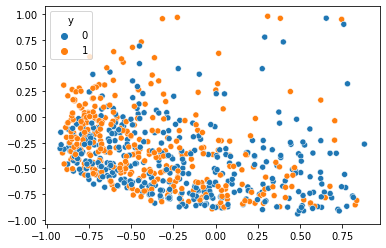

In [109]:
sns.scatterplot(x=compressed_X_train[:,0], y=compressed_X_train[:,1], hue=y_train, cmap='Dark2');

Imagem Original vs. Construção de uma Imagem

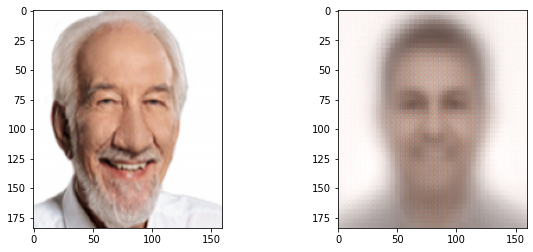

In [110]:
decompressed_X_train = X_decoded(compressed_X_train)

ith = np.random.randint(X_train.shape[0])
elected_person_image = X_train[ith]
elected_person_reconstructed_image = np.squeeze(decompressed_X_train[ith])

fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].imshow(BGR2RGB(elected_person_image));
axs[1].imshow(BGR2RGB(elected_person_reconstructed_image));

Teste Autoencoder

In [111]:
def reconstituir_foto(candidate_photo):
  compressed_X_train = X_encoded.predict(np.expand_dims(candidate_photo, axis=0))
  decompressed_X_train = X_decoded(compressed_X_train)

  candidate_reconstructed_image = np.squeeze(decompressed_X_train[0])

  fig, axs = plt.subplots(1, 2, figsize=(10,4))
  axs[0].imshow(BGR2RGB(candidate_photo));
  axs[1].imshow(BGR2RGB(candidate_reconstructed_image));

In [112]:
url_foto_lula = 'https://divulgacandcontas.tse.jus.br/candidaturas/oficial/2022/BR/BR/544/candidatos/893498/foto.jpg'
url_foto_bolsonaro = 'https://divulgacandcontas.tse.jus.br/candidaturas/oficial/2022/BR/BR/544/candidatos/908966/foto.jpeg'
foto_lula = open_image_internet(url_foto_lula)
foto_bolsonaro = open_image_internet(url_foto_bolsonaro)
foto_lula, foto_bolsonaro = get_resized_faces_aux(get_cropped_faces([foto_lula, foto_bolsonaro]), w_div_4*4, h_div_4*4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


1/1 [==============================] - 0s 61ms/step


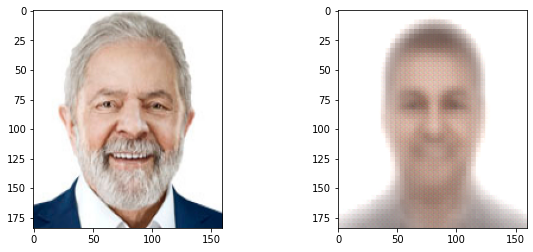

In [113]:
reconstituir_foto(foto_lula)

1/1 [==============================] - 0s 15ms/step


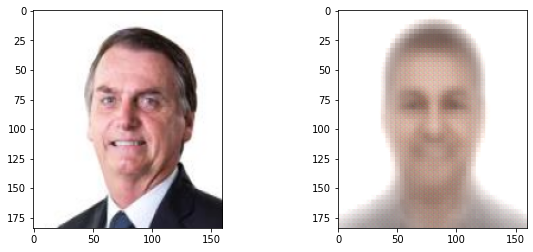

In [114]:
reconstituir_foto(foto_bolsonaro)